In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Install pyreadr library
!pip install pyreadr

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)

df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

df.shape

(2629440, 10)

In [4]:
# Fill Null Values using foward fill and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [5]:
df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation'],
      dtype='object')

# 1. Rocky Reach

## 1. Feature Engineering

In [6]:
df_rr_lagged = df.copy()

# Rocky Reach Headwater Elevation lag for the last 2 minutes
for lag in range(1, 3):
    df_rr_lagged[f'Rocky_Reach_Headwater_Elevation_lag_{lag}'] = df['Rocky_Reach_Headwater_Elevation'].shift(lag)

# Rocky Reach Discharge lag for the last 2 minutes
for lag in range(1, 3):
    df_rr_lagged[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df['Rocky_Reach_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows averaged from previous 90-105 minutes
for lag in range(90, 106):
    df_rr_lagged[f'Wells_Total_Discharge_lag_{lag}'] = df['Wells_Total_Discharge'].shift(lag)

# Chelan Flow Impact = flows averaged from previous 62-77 minutes
for lag in range(62, 78):
    df_rr_lagged[f'Chelan_Flow_lag_{lag}'] = df['Chelan_Flow'].shift(lag)

# Entiat Flow Impact = flows averaged from previous 15-30 minutes
for lag in range(15, 31):
    df_rr_lagged[f'Entiat_Flow_lag_{lag}'] = df['Entiat_Flow'].shift(lag)

df_rr_lagged.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_T

In [7]:
# List of unnecessary columns to drop
columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge','Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rr = df_rr_lagged.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rr.dropna(inplace=True)

df_rr.shape

(2629335, 54)

In [8]:
df_rr.columns

Index(['datetime_utc', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_Total_Discharge_lag_105', 'Chelan_Flow_lag_62',
       'Chelan_Flow_lag_63', 'Chelan_Flow_lag_64', 'Chelan_Flow_lag_65',
       'Chelan_Flow_lag_66', 'Chelan_Flow_lag_67', 'Chelan_Flow_lag_68',
       'Chelan_F

In [9]:
# Create a new dataframe with the filtered data for years before 2023
df_before_2023 = df_rr[df_rr['datetime_utc'].dt.year < 2023]

# Create a new dataframe with 2023 data 
df_2023 = df_rr[df_rr['datetime_utc'].dt.year == 2023]

# Check the results
print(df_before_2023.shape)
print(df_2023.shape)

(2103255, 54)
(525600, 54)


In [10]:
data = df_before_2023.drop(columns=['datetime_utc']).copy()
data.columns

Index(['Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_Total_Discharge_lag_105', 'Chelan_Flow_lag_62',
       'Chelan_Flow_lag_63', 'Chelan_Flow_lag_64', 'Chelan_Flow_lag_65',
       'Chelan_Flow_lag_66', 'Chelan_Flow_lag_67', 'Chelan_Flow_lag_68',
       'Chelan_Flow_lag_69', 'Ch

In [11]:
data.shape

(2103255, 53)

## 2. PCA

## Modeling

In [12]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = data.drop(columns=[target]) 
y = data[target]  # Target

**Optimal Components Found: 15**

In [13]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0019377738946997473
R-Squared for Rocky Reach Dam: 0.9950734771411752


In [14]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("10 Most Influential Features in 15 Components PCA for Rocky Reach")
print(feature_counts.head(10))

10 Most Influential Features in 15 Components PCA for Rocky Reach
Wells_Total_Discharge_lag_105    10
Wells_Total_Discharge_lag_95     10
Wells_Total_Discharge_lag_98      9
Wells_Total_Discharge_lag_100     9
Wells_Total_Discharge_lag_97      8
Wells_Total_Discharge_lag_90      8
Wells_Total_Discharge_lag_94      8
Wells_Total_Discharge_lag_101     8
Wells_Total_Discharge_lag_93      8
Wells_Total_Discharge_lag_102     7
dtype: int64


## Model Evaluation

In [15]:
data_2023 = df_2023.drop(columns=['datetime_utc']).copy()
data_2023.shape

(525600, 53)

In [16]:
target = 'Rocky_Reach_Headwater_Elevation'
X_eval = data_2023.drop(columns=[target]) 
y_eval = data_2023[target]  # Target

In [17]:
X_eval_pca_corrected = pca.transform(X_eval)

y_pred = model.predict(X_eval_pca_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0022323236157214274
R-Squared for Rocky Reach Dam: 0.9949456667415721


## Feature Selection Using Other Methods

## 3. Filter Methods: Using Correlation

## Modeling

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# Selecting the top k features that have the highest correlation with the target variable
selector = SelectKBest(f_regression, k= 15)  # k = No of features wanted
X_new = selector.fit_transform(X, y)

# Getting the selected feature names
selected_features = X.columns[selector.get_support()]

print("Selected features:", selected_features)

Selected features: Index(['Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2', 'Wells_Total_Discharge_lag_93',
       'Wells_Total_Discharge_lag_94', 'Wells_Total_Discharge_lag_95',
       'Wells_Total_Discharge_lag_96', 'Wells_Total_Discharge_lag_97',
       'Wells_Total_Discharge_lag_98', 'Wells_Total_Discharge_lag_99',
       'Wells_Total_Discharge_lag_100', 'Wells_Total_Discharge_lag_101',
       'Wells_Total_Discharge_lag_102', 'Wells_Total_Discharge_lag_103',
       'Wells_Total_Discharge_lag_104', 'Wells_Total_Discharge_lag_105'],
      dtype='object')


In [19]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.001191297160823114
R-Squared for Rocky Reach Dam: 0.9969712912788736


### Model Evaluation

In [20]:
X_eval_selector_corrected = selector.transform(X_eval)

y_pred = model.predict(X_eval_selector_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0013033722877497417
R-Squared for Rocky Reach Dam: 0.9970489592746804


## 3. Wrapper Methods: Recursive Feature Elimination (RFE)

## Modeling

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize the model you want to use
model = LinearRegression()

# Initialize RFE with the model and the number of features you want to select
rfe = RFE(estimator=model, n_features_to_select=15)  # Adjust the number of features to select

# Fit RFE
rfe.fit(X, y)

# Transform the data
X_rfe = rfe.transform(X)

# Getting the selected feature names
selected_features_rfe = X.columns[rfe.get_support()]

print("Selected features via RFE:", selected_features_rfe)

Selected features via RFE: Index(['Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_2', 'Entiat_Flow_lag_15',
       'Entiat_Flow_lag_16', 'Entiat_Flow_lag_17', 'Entiat_Flow_lag_18',
       'Entiat_Flow_lag_19', 'Entiat_Flow_lag_20', 'Entiat_Flow_lag_21',
       'Entiat_Flow_lag_23', 'Entiat_Flow_lag_24', 'Entiat_Flow_lag_26',
       'Entiat_Flow_lag_28', 'Entiat_Flow_lag_30'],
      dtype='object')


In [23]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0012028529977401435
R-Squared for Rocky Reach Dam: 0.9969419121573567


## Model Evaluation

In [24]:
X_eval_rfe_corrected = rfe.transform(X_eval)

y_pred = model.predict(X_eval_rfe_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0013221480300501607
R-Squared for Rocky Reach Dam: 0.9970064480285097


## 4. Embedded Methods: Lasso (L1 Regularization)

## Modeling

In [25]:
from sklearn.linear_model import LassoCV

# LassoCV automatically selects the best regularization parameter via cross-validation
lasso = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit Lasso model
lasso.fit(X, y)

# Select features where the coefficient is non-zero
selected_features_lasso = X.columns[(lasso.coef_ != 0)]

print("Selected features via Lasso:", selected_features_lasso)

Selected features via Lasso: Index(['Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Total_Discharge_lag_1', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97'],
      dtype='object')


In [26]:
# Manual feature selection based on Lasso's non-zero coefficients
X_lasso = X[selected_features_lasso]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0012781725814497438
R-Squared for Rocky Reach Dam: 0.9967504225042669


## Model Evaluation

In [27]:
X_eval_lasso_corrected = X_eval[selected_features_lasso]

y_pred = model.predict(X_eval_lasso_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0014168289209845544
R-Squared for Rocky Reach Dam: 0.9967920755367181


## 5. Autoencoders

In [28]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
# X is the features matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Build the Autoencoder

In [33]:
input_dim = X_scaled.shape[1]  # Number of features
encoding_dim = 32  # Set the size of the encoded representations

# This is the input layer
input_layer = keras.Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_layer, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_layer, encoded)

### Compile and Train the Encoder

In [38]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Split your data into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
6573/6573 [==============================] - 3s 464us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 2/50
6573/6573 [==============================] - 3s 442us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 3/50
6573/6573 [==============================] - 3s 444us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 4/50
6573/6573 [==============================] - 3s 445us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 5/50
6573/6573 [==============================] - 3s 455us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 6/50
6573/6573 [==============================] - 3s 458us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 7/50
6573/6573 [==============================] - 3s 459us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 8/50
6573/6573 [==============================] - 3s 459us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 9/50
6573/6573 [==============================] - 3s 460us/step - loss: 1.9996 - val_loss: 2.0014
Epoch 10/50
6573/6573 [==============================] - 3s 458u

In [39]:
# Use encoder to transform the data
X_encoded = encoder.predict(X_scaled)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

65727/65727 [==============================] - 12s 186us/step
Mean Squared Error for Rocky Reach Dam: 0.008261297834840151
R-Squared for Rocky Reach Dam: 0.9789967896986218


### Model Evaluation

In [40]:
scaler = StandardScaler()
X_eval_scaled = scaler.fit_transform(X_eval)

X_eval_encoder_corrected = encoder.predict(X_eval_scaled)

y_pred = model.predict(X_eval_encoder_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

16425/16425 [==============================] - 3s 179us/step
Mean Squared Error for Rocky Reach Dam: 0.0767339313613493
R-Squared for Rocky Reach Dam: 0.8262622593793392


# Using LSTM instead of Feature Engineering and Feature Selection

In [43]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## 1. Data Preparation

In [44]:
df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation'],
      dtype='object')

In [46]:
df.shape

(2629440, 10)

In [45]:
# Filter the data from 2022 to 2023, excluding 2023 for now
df_filtered = df[df['datetime_utc'].dt.year < 2023]
df_filtered.shape

(2103360, 10)

In [51]:
target = 'Rocky_Reach_Headwater_Elevation'
X = df_filtered.drop(['datetime_utc','datetime_stamp', target], axis=1)
y = df_filtered[target]

# Normalize the features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Define the sequence length
sequence_length = 100  # For example, 100 minutes of data to predict the next minute

# Define batch size
batch_size = 64

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)

# Create TimeseriesGenerator for training and testing
train_generator = TimeseriesGenerator(X_train, y_train,
                                      length=sequence_length,
                                      batch_size=batch_size)

test_generator = TimeseriesGenerator(X_test, y_test,
                                     length=sequence_length,
                                     batch_size=batch_size)

## 2. Building and training the LSTM Model

In [52]:
model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, X_scaled.shape[1])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model with validation data
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
23004/23004 [==============================] - 865s 38ms/step - loss: 0.0189 - val_loss: 0.0167
Epoch 2/10
23004/23004 [==============================] - 821s 36ms/step - loss: 0.0172 - val_loss: 0.0144
Epoch 3/10
23004/23004 [==============================] - 814s 35ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 4/10
23004/23004 [==============================] - 837s 36ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 5/10
23004/23004 [==============================] - 854s 37ms/step - loss: 0.0167 - val_loss: 0.0151
Epoch 6/10
23004/23004 [==============================] - 841s 37ms/step - loss: nan - val_loss: nan
Epoch 7/10
23004/23004 [==============================] - 841s 37ms/step - loss: nan - val_loss: nan
Epoch 8/10
 1221/23004 [>.............................] - ETA: 11:33 - loss: nan

KeyboardInterrupt: 

## 3. Model Evaluation

In [53]:
# Prepare the 2023 data
df_eval = df[df['datetime_utc'].dt.year == 2023]
X_eval = df_eval.drop(['datetime_utc','datetime_stamp', target], axis=1)
y_eval = df_eval[target]

X_eval_scaled = scaler_x.transform(X_eval)
y_eval_scaled = scaler_y.transform(y_eval.values.reshape(-1, 1))

# Prepare the generator for evaluation
eval_generator = TimeseriesGenerator(X_eval_scaled, y_eval_scaled,
                                     length=sequence_length,
                                     batch_size=32)

# Predict
predictions_scaled = model.predict(eval_generator)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Evaluate (assuming you transform predictions back to the original scale)
from sklearn.metrics import mean_squared_error, r2_score

y_eval_true = y_eval[sequence_length:]
print("Mean Squared Error:", mean_squared_error(y_eval_true, predictions))
print("R2 Score:", r2_score(y_eval_true, predictions))

16422/16422 [==============================] - 130s 8ms/step


ValueError: Input contains NaN.

# Modeling Headwater Elevation Changes instead of Absolute Headwater Elevation

## Feature Engineering

In [30]:
df1 = df.copy()

# Calculate change in headwater elevation for all data
df1['Rocky_Reach_Headwater_Elevation_Change'] = df1['Rocky_Reach_Headwater_Elevation'].diff()

df1.fillna(method='bfill', inplace=True)

df1.isna().sum()

datetime_utc                              0
datetime_stamp                            0
Wells_Total_Discharge                     0
Chelan_Flow                               0
Entiat_Flow                               0
Rocky_Reach_Total_Discharge               0
Wenatchee_Flow                            0
Rock_Island_Total_Discharge               0
Rock_Island_Headwater_Elevation           0
Rocky_Reach_Headwater_Elevation           0
Rocky_Reach_Headwater_Elevation_Change    0
dtype: int64

In [31]:
# Rocky Reach Headwater Elevation lag for the last 3 minutes
for lag in range(1, 4):
    df1[f'Rocky_Reach_Headwater_Elevation_lag_{lag}'] = df['Rocky_Reach_Headwater_Elevation'].shift(lag)

# Rocky Reach Discharge lag for the last 3 minutes
for lag in range(1, 4):
    df1[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df['Rocky_Reach_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows averaged from previous 90-105 minutes
for lag in range(90, 106):
    df1[f'Wells_Total_Discharge_lag_{lag}'] = df['Wells_Total_Discharge'].shift(lag)

# Chelan Flow Impact = flows averaged from previous 62-77 minutes
for lag in range(62, 78):
    df1[f'Chelan_Flow_lag_{lag}'] = df['Chelan_Flow'].shift(lag)

# Entiat Flow Impact = flows averaged from previous 15-30 minutes
for lag in range(15, 31):
    df1[f'Entiat_Flow_lag_{lag}'] = df['Entiat_Flow'].shift(lag)

df1.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_Change',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Headwater_Elevation_lag_3',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2',
       'Rocky_Reach_Total_Discharge_lag_3', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_

In [32]:
# List of unnecessary columns to drop
columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge','Chelan_Flow', 'Entiat_Flow',
                   'Rocky_Reach_Headwater_Elevation', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df1_rr = df1.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df1_rr.dropna(inplace=True)

df1_rr.shape

(2629335, 56)

In [33]:
# Create a new dataframe with the filtered data for years before 2023
df1_before_2023 = df1_rr[df1_rr['datetime_utc'].dt.year < 2023]

# Create a new dataframe with 2023 data 
df1_2023 = df1_rr[df1_rr['datetime_utc'].dt.year == 2023]

# Check the results
print(df1_before_2023.shape)
print(df1_2023.shape)

(2103255, 56)
(525600, 56)


In [34]:
data1 = df1_before_2023.drop(columns=['datetime_utc']).copy()
data1.columns

Index(['Rocky_Reach_Headwater_Elevation_Change',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Headwater_Elevation_lag_3',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2',
       'Rocky_Reach_Total_Discharge_lag_3', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_Total_Discharge_lag_105', 'Chelan_Flow_lag_62',
       'Chelan_Flow_lag_63', 'Chelan_Flow_lag_64', 'Chelan_Flow_lag_65',
      

In [35]:
data1.shape

(2103255, 55)

## Feature Selection Using PCA

In [36]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation_Change'
X = data1.drop(columns=[target]) 
y = data1[target]  # Target

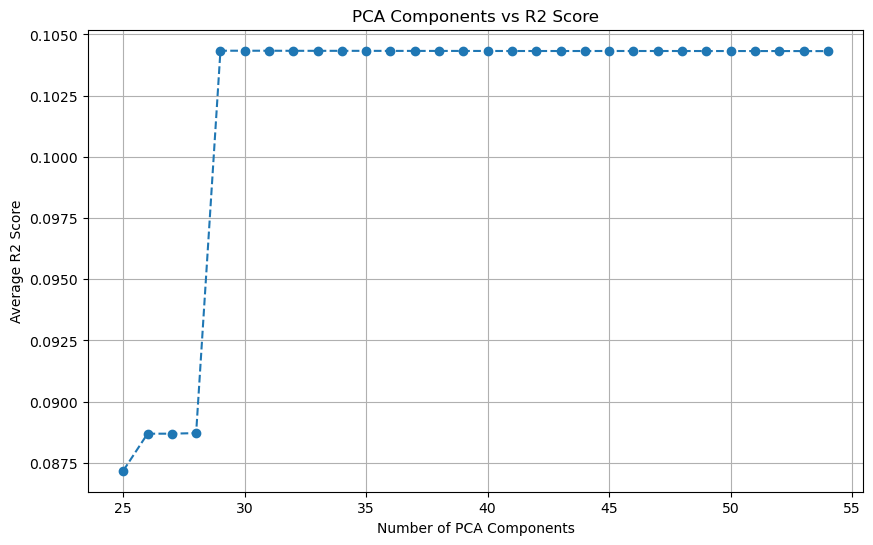

In [37]:
# Define a range of components to test
component_range = range(25, 55)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))


# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

## Modeling

In [38]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.001109115854478554
R-Squared for Rocky Reach Dam: 0.14341573794181706


In [39]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("10 Most Influential Features in _ Components PCA for Rocky Reach")
print(feature_counts.head(10))

10 Most Influential Features in _ Components PCA for Rocky Reach
Wells_Total_Discharge_lag_101    14
Wells_Total_Discharge_lag_96     13
Wells_Total_Discharge_lag_95     13
Wells_Total_Discharge_lag_100    13
Wells_Total_Discharge_lag_94     13
Wells_Total_Discharge_lag_97     12
Wells_Total_Discharge_lag_99     12
Wells_Total_Discharge_lag_93     12
Wells_Total_Discharge_lag_102    12
Wells_Total_Discharge_lag_98     12
dtype: int64


## Model Evaluation

In [40]:
data1_2023 = df1_2023.drop(columns=['datetime_utc']).copy()
data1_2023.shape

(525600, 55)

In [41]:
target = 'Rocky_Reach_Headwater_Elevation_Change'
X_eval = data1_2023.drop(columns=[target]) 
y_eval = data1_2023[target]  # Target

In [42]:
X_eval_pca_corrected = pca.transform(X_eval)
y_pred = model.predict(X_eval_pca_corrected)

print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0012216799665308827
R-Squared for Rocky Reach Dam: 0.15034642601121062


# Rock Island

## Feature Engineering

In [43]:
df_ri_lagged = df.copy()

# Rock Island Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
    df_ri_lagged[f'Rock_Island_Headwater_Elevation_lag_{lag}'] = df['Rock_Island_Headwater_Elevation'].shift(lag)

# Rocky Island Discharge lag for last 2 minutes
for lag in range(1, 3):
    df_ri_lagged[f'Rock_Island_Total_Discharge_lag_{lag}'] = df['Rock_Island_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows from last 15-30 minutes.
for lag in range(15, 31):
    df_ri_lagged[f'Wenatchee_Flow_lag_{lag}'] = df['Wenatchee_Flow'].shift(lag)

# Rocky Reach Discharge Impact = Discharge lags from last 60 to 90 minutes
for lag in range(60, 91):
    df_ri_lagged[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df['Rocky_Reach_Total_Discharge'].shift(lag)

In [44]:
# List of columns to drop
columns_to_drop = ['datetime_stamp', 'Wells_Total_Discharge', 'Rock_Island_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rocky_Reach_Headwater_Elevation']

# Create the DataFrame df_ri by dropping the specified columns
df_ri = df_ri_lagged.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_ri.dropna(inplace=True)
df_ri.shape

(2629350, 53)

In [45]:
# Create a new dataframe with the filtered data for years before 2023
df_before_2023 = df_ri[df_ri['datetime_utc'].dt.year < 2023]

# Create a new dataframe with 2023 data 
df_2023 = df_ri[df_ri['datetime_utc'].dt.year == 2023]

# Check the results
print(df_before_2023.shape)
print(df_2023.shape)

(2103270, 53)
(525600, 53)


In [46]:
data = df_before_2023.drop(columns=['datetime_utc']).copy()
data.columns

Index(['Rock_Island_Headwater_Elevation',
       'Rock_Island_Headwater_Elevation_lag_1',
       'Rock_Island_Headwater_Elevation_lag_2',
       'Rock_Island_Total_Discharge_lag_1',
       'Rock_Island_Total_Discharge_lag_2', 'Wenatchee_Flow_lag_15',
       'Wenatchee_Flow_lag_16', 'Wenatchee_Flow_lag_17',
       'Wenatchee_Flow_lag_18', 'Wenatchee_Flow_lag_19',
       'Wenatchee_Flow_lag_20', 'Wenatchee_Flow_lag_21',
       'Wenatchee_Flow_lag_22', 'Wenatchee_Flow_lag_23',
       'Wenatchee_Flow_lag_24', 'Wenatchee_Flow_lag_25',
       'Wenatchee_Flow_lag_26', 'Wenatchee_Flow_lag_27',
       'Wenatchee_Flow_lag_28', 'Wenatchee_Flow_lag_29',
       'Wenatchee_Flow_lag_30', 'Rocky_Reach_Total_Discharge_lag_60',
       'Rocky_Reach_Total_Discharge_lag_61',
       'Rocky_Reach_Total_Discharge_lag_62',
       'Rocky_Reach_Total_Discharge_lag_63',
       'Rocky_Reach_Total_Discharge_lag_64',
       'Rocky_Reach_Total_Discharge_lag_65',
       'Rocky_Reach_Total_Discharge_lag_66',
       'Ro

In [47]:
data.shape

(2103270, 52)

## Modeling

In [48]:
# Separate features and target
target = 'Rock_Island_Headwater_Elevation'
X = data.drop(columns=[target]) 
y = data[target]  # Target

**Optimal Components-22**

In [49]:
pca = PCA(n_components=22)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0008596506941184527
R-Squared for Rocky Reach Dam: 0.9948039889254207


## Model Evaluation

In [50]:
data_2023 = df_2023.drop(columns=['datetime_utc']).copy()
data_2023.shape

(525600, 52)

In [51]:
target = 'Rock_Island_Headwater_Elevation'
X_eval = data_2023.drop(columns=[target]) 
y_eval = data_2023[target]  # Target

In [52]:
X_eval_pca_corrected = pca.transform(X_eval)

y_pred = model.predict(X_eval_pca_corrected)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_eval, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_eval, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0008193723009927348
R-Squared for Rocky Reach Dam: 0.9963870489807473


In [53]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("10 Most Influential Features in 22 Components PCA for Rock Island")
print(feature_counts.head(10))

10 Most Influential Features in 22 Components PCA for Rock Island
Rocky_Reach_Total_Discharge_lag_60    12
Rocky_Reach_Total_Discharge_lag_90    11
Rocky_Reach_Total_Discharge_lag_71     9
Rocky_Reach_Total_Discharge_lag_79     8
Rocky_Reach_Total_Discharge_lag_75     8
Rocky_Reach_Total_Discharge_lag_74     7
Rocky_Reach_Total_Discharge_lag_64     7
Rocky_Reach_Total_Discharge_lag_68     7
Rocky_Reach_Total_Discharge_lag_67     7
Rocky_Reach_Total_Discharge_lag_70     7
dtype: int64
